In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import utils
from scipy.optimize import least_squares, curve_fit, minimize, differential_evolution
import numpy as np
import os
import re
from tqdm import tqdm
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from DataLoader import DataLoader
import datetime as dt
import statsmodels.api as sm
import joblib as joblib
import Calibration as calibration
import yfinance as yf

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.listdir('params')

['futures_loss_diffevo.parquet',
 'futures_loss_lbfgs.parquet',
 'params_20060224_20100101.parquet',
 'params_20060224_20230831.parquet',
 'params_20060224_20230831_fixed.parquet',
 'params_diffevo_20060225_20230831.parquet',
 'params_futures_20060224_20230831.parquet',
 'params_futures_diffevo_20060224_20230831.parquet',
 'params_futures_lbfgs_20060224_20230831.parquet']

In [4]:
start, end = '2005-02-24', '2023-08-31'
spx = yf.download("^SPX", start=start, end=end)[['High', 'Low']]

start = '2006-02-24'
dates = spx.index

[*********************100%***********************]  1 of 1 completed


In [5]:
rv_estim = np.log(spx['High'] / spx['Low']).squeeze().rename("RV")
rv_estim.shape

(4661,)

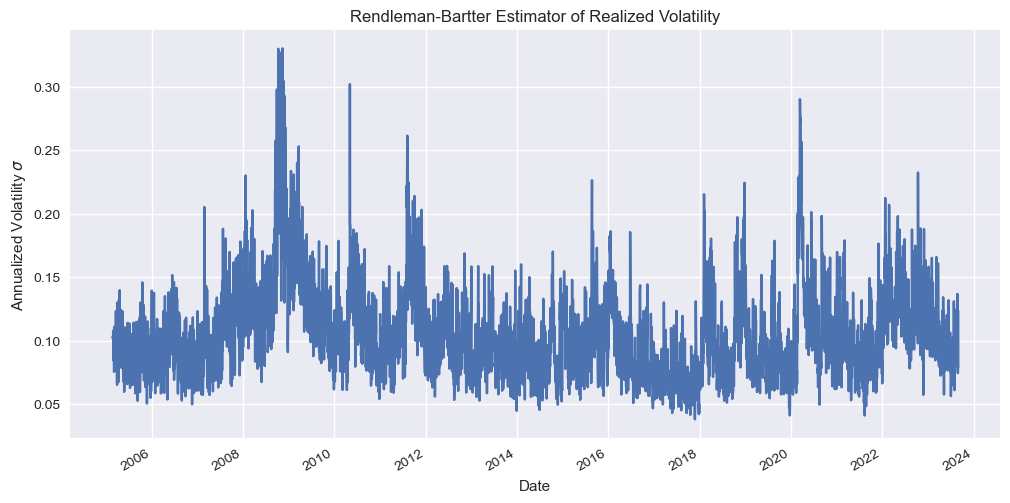

In [6]:
(rv_estim**.5).plot(figsize=(12, 6))
plt.title("Rendleman-Bartter Estimator of Realized Volatility")
plt.ylabel(r"Annualized Volatility $\sigma$")
plt.show()

In [28]:
log_vol_diff = np.log(rv_estim ** .5).diff()
xaxis = np.linspace(log_rv_diff.min(), log_rv_diff.max(), 100)
mu, sig = log_rv_diff.mean(), log_rv_diff.std()

def normal_density(x, mu=0., sig=1.):
    return np.exp(-(x - mu)**2 / (2*sig*sig)) / (sig * np.sqrt(2*np.pi))

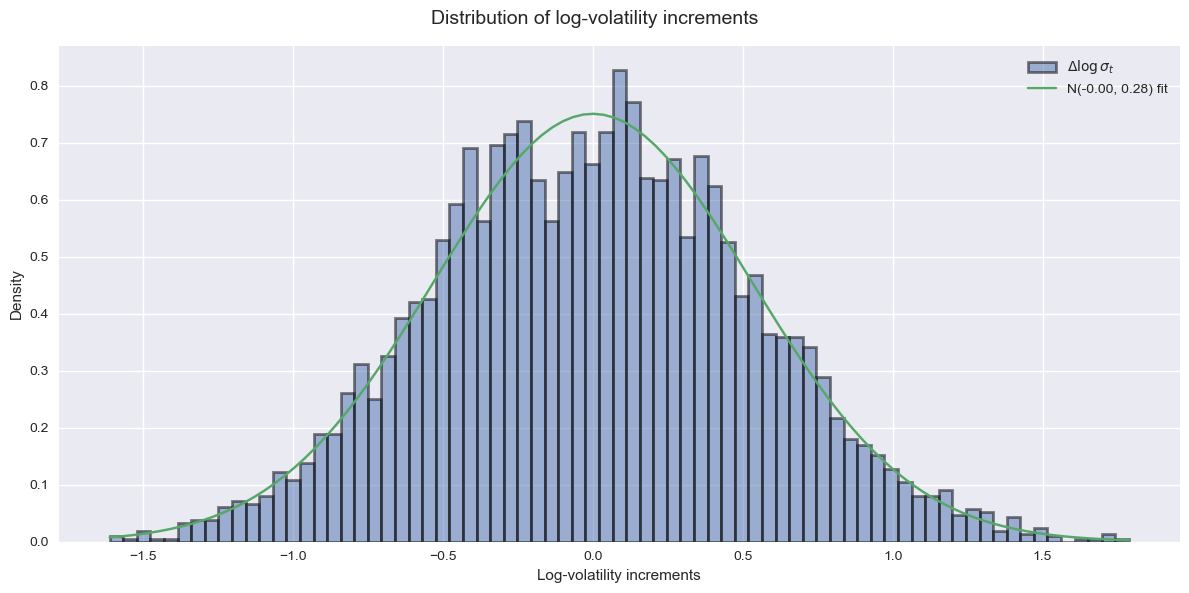

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Distribution of log-volatility increments", fontsize=14)

ax.hist(log_rv_diff, bins=75, alpha=.5, lw=2, edgecolor='black', density=True, label=r'$\Delta\log\sigma_t$')
ax.plot(xaxis, normal_density(xaxis, mu, sig), label=f"N({mu:.2f}, {sig**2:.2f}) fit")
ax.set_xlabel("Log-volatility increments"); ax.set_ylabel("Density")
ax.legend()

fig.tight_layout()
plt.show()

# Autocorrelation and model fits

In [7]:
n_lags = 252
lags = np.arange(n_lags) + 1
rv_acf = sm.tsa.acf(rv_estim, nlags=n_lags)[1:]

In [8]:
# fit power-law decay for ACF
paolo_mask = (lags >= 20)  # exclude low lags

paolo_c, paolo_m = sm.OLS(
    np.log(rv_acf[paolo_mask]), sm.add_constant(np.log(lags[paolo_mask]))
).fit().params

paolo = np.exp(paolo_c) * np.power(lags[paolo_mask], paolo_m)

H_paolo = (2 + paolo_m) / 2

#### ACF in rough vol

$$
\log(1 - \rho(\Delta)) \, = \, a \, + \, 2H\log\Delta
$$

Therefore, $H$ can be estimated from:
$$
\log(1 - \rho(\Delta)) \sim \beta\log\Delta \, \Rightarrow \, H = \frac\beta2
$$

In [9]:
# fit rough volatility correlation function
rough_c, rough_m = sm.OLS(
    np.log(1 - rv_acf), sm.add_constant(np.log(lags))
).fit().params

rough_acf = 1 - np.exp(rough_c) * np.power(lags, rough_m)

H_rough = 0.5 * rough_m

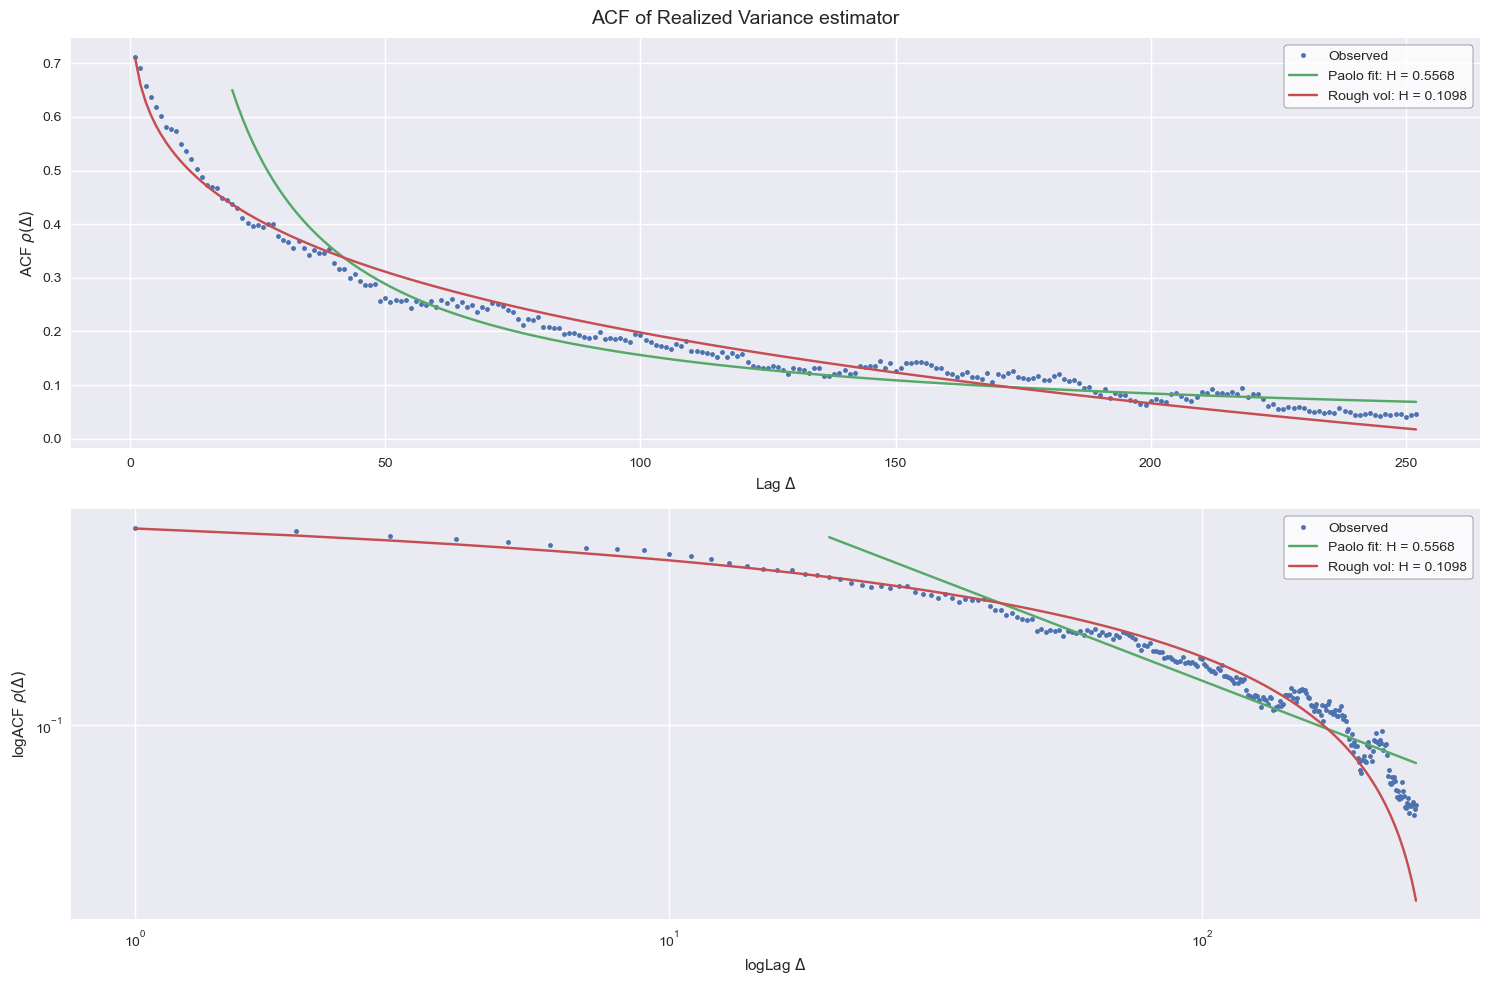

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("ACF of Realized Variance estimator", fontsize=14)

axs[0].plot(lags, rv_acf, lw=0, marker='.', label="Observed")
axs[1].loglog(lags, rv_acf, lw=0, marker='.', label="Observed")

axs[0].plot(lags[paolo_mask], paolo, label=f"Paolo fit: H = {H_paolo:.4f}")
axs[1].loglog(lags[paolo_mask], paolo, label=f"Paolo fit: H = {H_paolo:.4f}")

axs[0].plot(lags, rough_acf, label=f"Rough vol: H = {H_rough:.4f}")
axs[1].loglog(lags, rough_acf, label=f"Rough vol: H = {H_rough:.4f}")

for i, ax in enumerate(axs):
    ax.set_xlabel(("log")*i + r"Lag $\Delta$")
    ax.set_ylabel(("log")*i + r"ACF $\rho(\Delta)$")
    ax.legend(loc='upper right', frameon=True, facecolor='white', edgecolor='black')
fig.tight_layout()
plt.show()

# Rolling estimation

As Mikko does, we do a rolling window estimation of $H$ with a window of 252 days and we test different numbers of lags to include in the regression. The authors settle for 6 but claim there is not a lot of difference.

In [11]:
ols_window = 252
ols_sizes = np.array([
    5, 8, 10, 12, 15, 21
])

In [12]:
def rough_vol_regr(acf, lags):
    return sm.OLS(
        np.log(1 - acf), sm.add_constant(np.log(lags))
    ).fit().params

def fit_rough_vol(series, nlags=10):
    lags = np.arange(1, nlags+1)
    acf = sm.tsa.acf(series, nlags=nlags)[1:]
    params = rough_vol_regr(acf, lags)
    return params[1]

In [13]:
rv_roll = rv_estim.rolling(ols_window)

In [14]:
ols_h = pd.DataFrame(
    {str(m): rv_roll.apply(lambda x: fit_rough_vol(x, nlags=m)) / 2
     for m in tqdm(ols_sizes)}
).dropna()

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.14s/it]


In [15]:
ols_h.describe()[1:]

,5,8,10,12,15,21
mean,0.099344,0.104204,0.101974,0.104001,0.105381,0.106726
std,0.085397,0.076887,0.073472,0.070012,0.069167,0.068677
min,-0.053620,-0.036643,-0.019357,-0.001895,0.002779,0.011786
25%,0.040406,0.048018,0.043907,0.050744,0.053952,0.056905
50%,0.079555,0.089823,0.093259,0.098921,0.103093,0.098212
75%,0.163580,0.163438,0.152034,0.143277,0.142483,0.134089
max,0.377368,0.402927,0.404244,0.400072,0.394775,0.401880


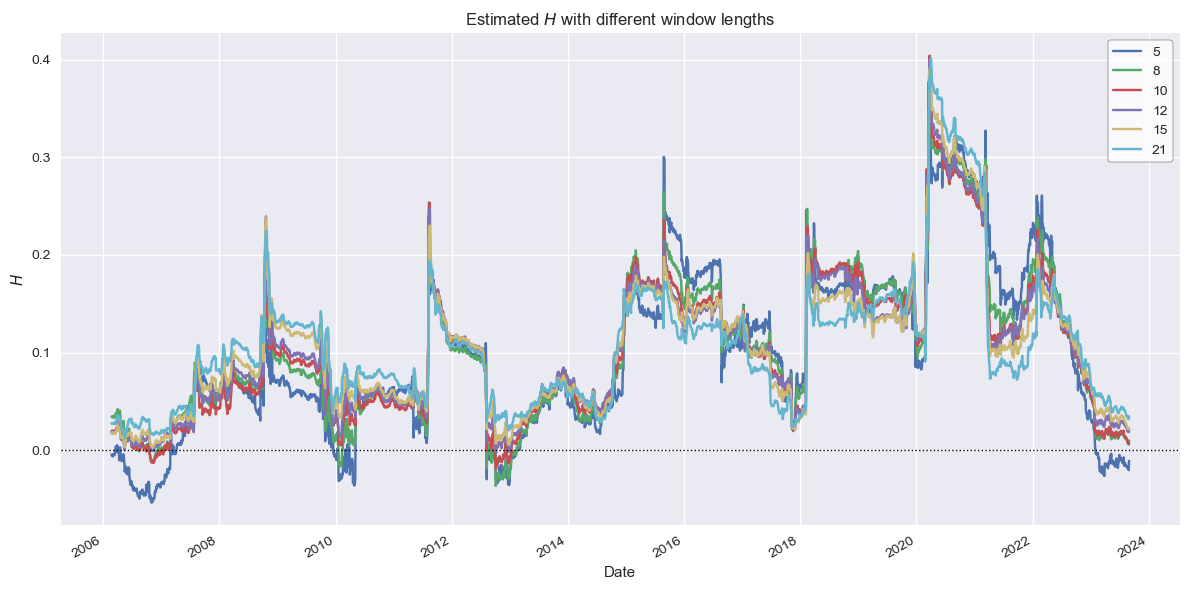

In [16]:
ols_h.plot(figsize=(12, 6))
plt.axhline(0, ls=':', lw=1, color='black')
plt.title(r"Estimated $H$ with different window lengths"); plt.ylabel(r"$H$")
plt.legend(frameon=True, facecolor='white', edgecolor='black')
plt.tight_layout(); plt.show()

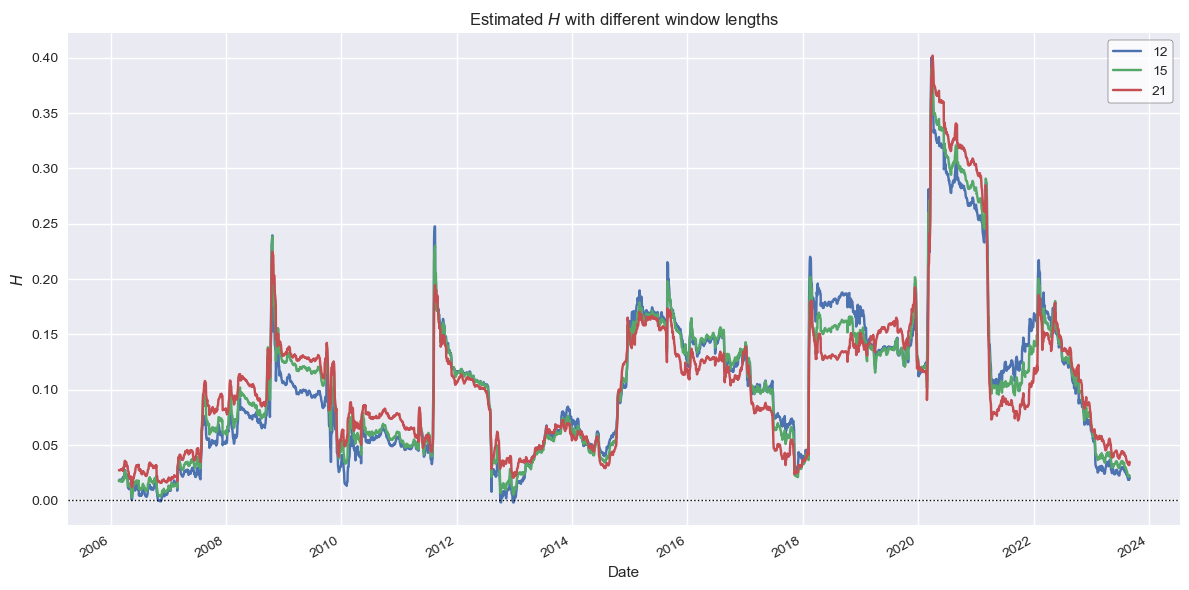

In [17]:
ols_h.iloc[:, -3:].plot(figsize=(12, 6))
plt.axhline(0, ls=':', lw=1, color='black')
plt.title(r"Estimated $H$ with different window lengths"); plt.ylabel(r"$H$")
plt.legend(frameon=True, facecolor='white', edgecolor='black')
plt.tight_layout(); plt.show()

We choose 15 lags.

In [18]:
ols_h = ols_h.get('15', ols_h)

# Compare with rough Bergomi $H$

In [33]:
risks = {
    'Lehman bankruptcy': dt.date(2008, 9, 15),
    'Flash Crash': dt.date(2010, 5, 6),
    'Greek Debt': dt.date(2012, 10, 1),
    'COVID': dt.date(2020, 2, 15),
    'Russia invasion': dt.date(2022, 2, 24)
}

markers = 'v<^>d'

In [23]:
rbH = pd.read_parquet(
    f"params/params_futures_diffevo_{''.join(start.split('-'))}_{''.join(end.split('-'))}.parquet"
)['H'].dropna()

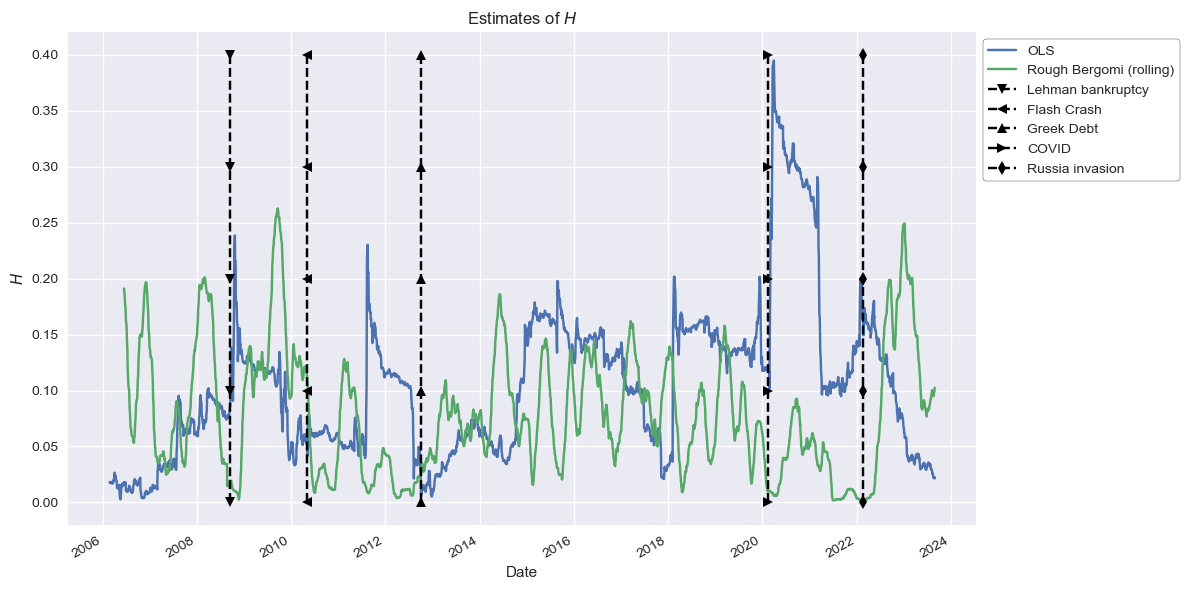

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ols_h.plot(ax=ax, label='OLS')
rbH.rolling(50).mean().plot(ax=ax, label='Rough Bergomi (rolling)')

ax.set_title(r"Estimates of $H$")
ax.set_xlabel("Date"); ax.set_ylabel(r"$H$")
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(0., .4, 5),
            ls='--', color='black', label=name, marker=markers[i])
ax.legend(bbox_to_anchor=(1,1), frameon=True, facecolor='white', edgecolor='black')

fig.tight_layout()
plt.show()

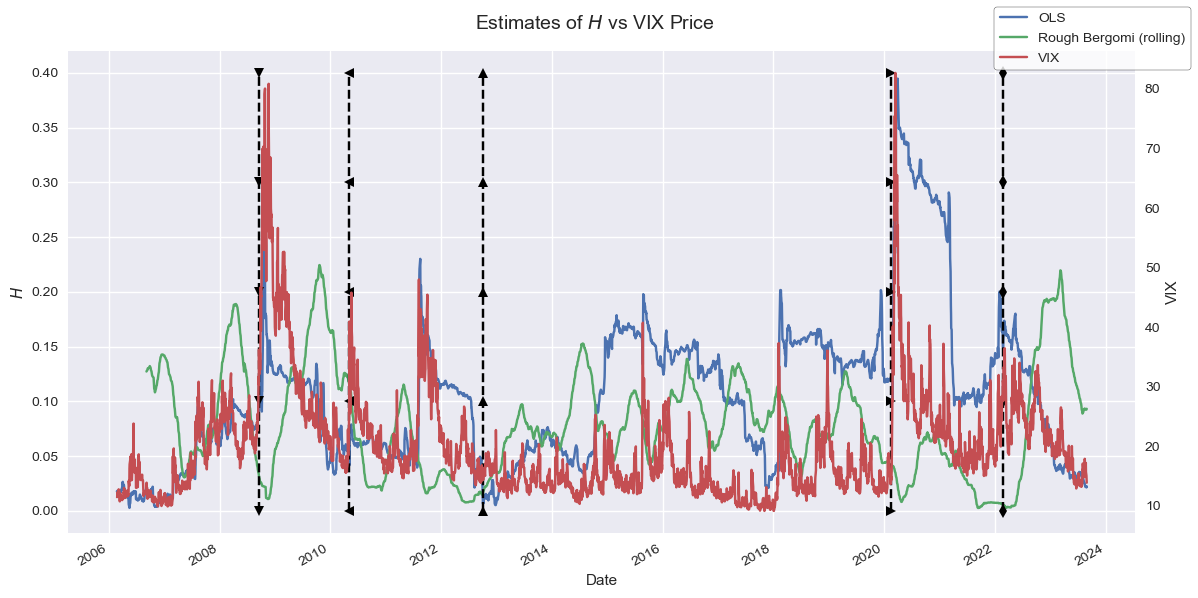

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax2 = ax.twinx()
ax2.plot(
    yf.download("^VIX", start=start, end=end, progress=False)['Adj Close'],
    color='C2', label='VIX'
)
ax2.set_ylabel("VIX")
ax2.grid(False)

ols_h.plot(ax=ax, label='OLS')
rbH.rolling(100).mean().plot(ax=ax, label='Rough Bergomi (rolling)')

fig.suptitle(r"Estimates of $H$ vs VIX Price", fontsize=14)
ax.set_xlabel("Date"); ax.set_ylabel(r"$H$")
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(0., .4, 5),
            ls='--', color='black', marker=markers[i])

fig.legend(frameon=True, facecolor='white', edgecolor='black')

fig.tight_layout()
plt.show()

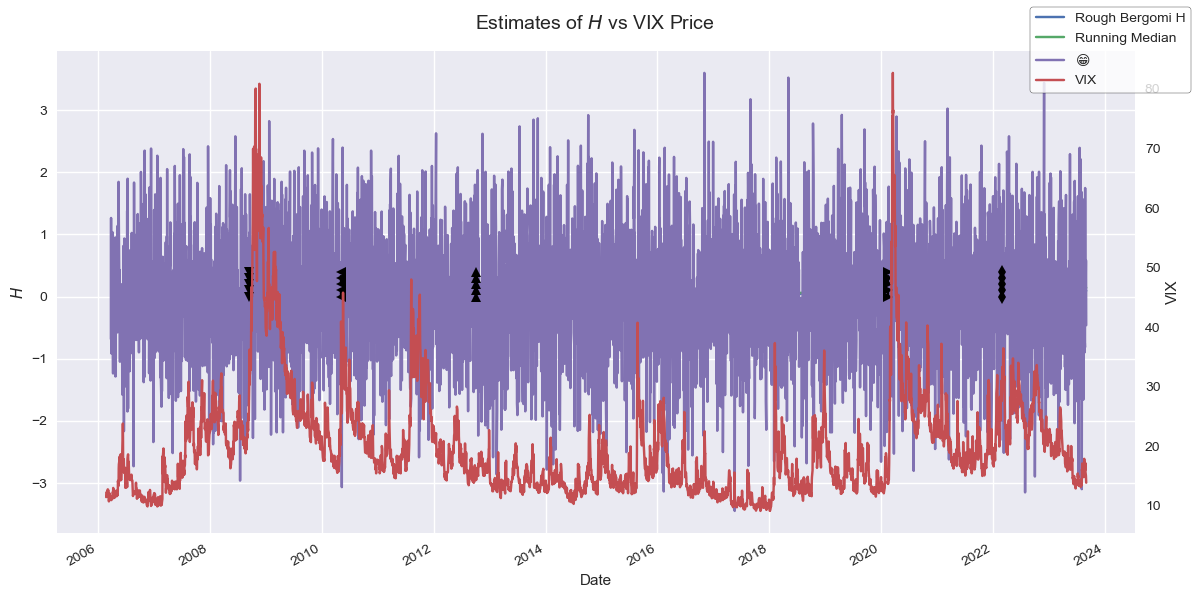

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax2 = ax.twinx()
ax2.plot(
    yf.download("^VIX", start=start, end=end, progress=False)['Adj Close'],
    color='C2', label='VIX'
)
ax2.set_ylabel("VIX")
ax2.grid(False)

rbH.rolling(100).mean().plot(ax=ax, label='Rough Bergomi H')
rbH.rolling(252).median().plot(ax=ax, label='Running Median')
ax.plot(rbH.index, np.random.normal(size=rbH.shape[0]), label='$\U0001F601$', color='C3')

fig.suptitle(r"Estimates of $H$ vs VIX Price", fontsize=14)
ax.set_xlabel("Date"); ax.set_ylabel(r"$H$")
for i, (name, dd) in enumerate(risks.items()):
    ax.plot([dd]*5, np.linspace(0., .4, 5),
            ls='--', color='black', marker=markers[i])

fig.legend(frameon=True, facecolor='white', edgecolor='black')

fig.tight_layout()
plt.show()

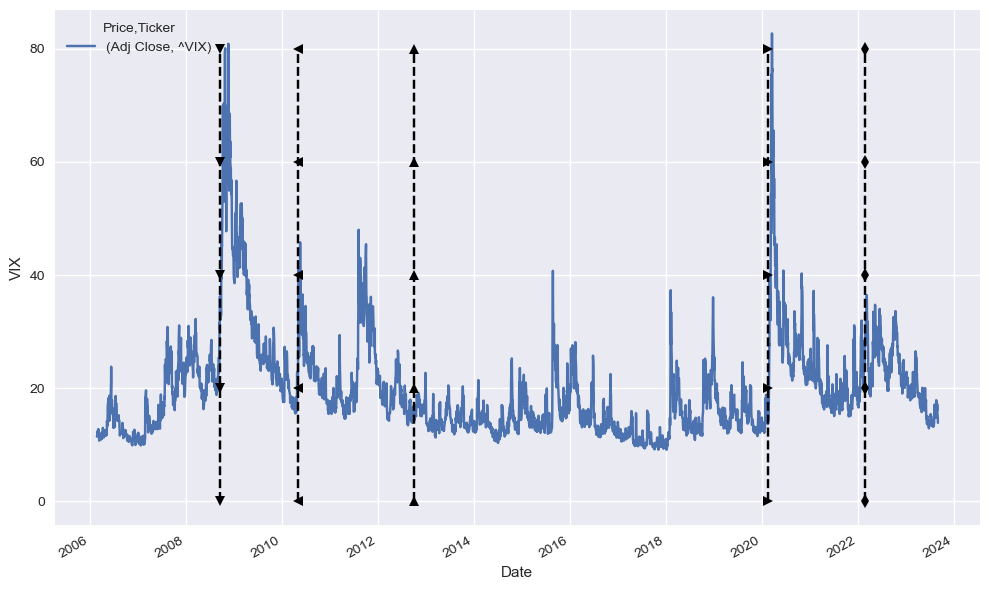

In [47]:
yf.download("^VIX", start=start, end=end, progress=False)[['Adj Close']].plot(figsize=(10, 6))
for i, (name, dd) in enumerate(risks.items()):
    plt.plot([dd]*5, np.linspace(0., 80, 5),
             ls='--', color='black', label=name, marker=markers[i])
plt.ylabel("VIX")
plt.tight_layout(); plt.show()